In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from lightkurve import search_lightcurvefile
from requests.exceptions import HTTPError
from astropy.coordinates import SkyCoord
from astroquery.mast import Tesscut
from astropy.timeseries import LombScargle
from photutils import CircularAperture, aperture_photometry

import astropy.units as u

In [3]:
coord = SkyCoord.from_name('DS Tuc')
slcf = search_lightcurvefile(coord, mission='TESS')

lc = slcf.download_all()
pdcsap = lc.PDCSAP_FLUX.stitch()

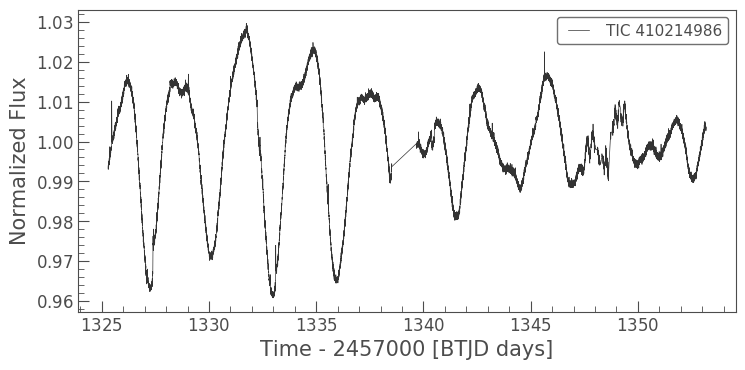

In [39]:
time = pdcsap.time
flux = pdcsap.flux

notnanflux = ~np.isnan(flux)
flux = flux[notnanflux & (time > 1326) & (time < 1335)]
time = time[notnanflux & (time > 1326) & (time < 1335)]
flux /= np.mean(flux)
pdcsap.plot()

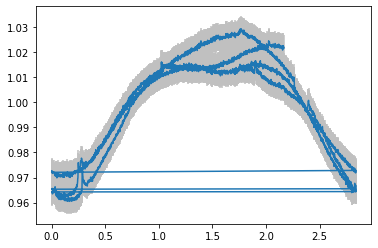

In [40]:
plt.errorbar(time % best_period.value, flux, 0.005, ecolor='silver');

In [41]:
periods = np.linspace(1, 5, 1000) * u.day
freqs = 1 / periods
powers = LombScargle(time[~np.isnan(flux)] * u.day, flux[~np.isnan(flux)]).power(freqs)
best_period = periods[powers.argmax()]

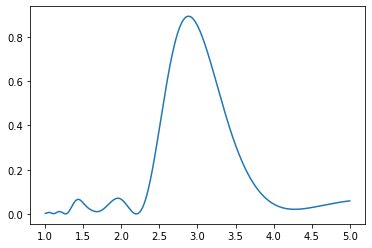

In [42]:
plt.plot(periods, powers)

In [43]:
best_period

<Quantity 2.88188188 d>

In [44]:
from fleck import Star
from emcee import EnsembleSampler
from multiprocessing import Pool
from corner import corner

u_ld = [0.46, 0.11]
contrast = 0.7
phases = (time % best_period.value) / best_period.value
s = Star(contrast, u_ld, n_phases=len(time), rotation_period=best_period.value)

In [45]:
init_lons = np.array([0, 40, 340])
init_lats = [0, 60, 0]
init_rads = [0.01, 0.3, 0.38]

yerr = 0.005

init_p = np.concatenate([init_lons, init_lats, init_rads])

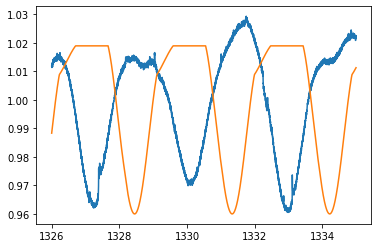

In [46]:
p = init_p.copy()

lons = p[0:3]
lats = p[3:6]
rads = p[6:9]

lc = s.light_curve(lons[:, None] * u.deg, lats[:, None] * u.deg, rads[:, None], 
                   inc_stellar=90*u.deg, times=time, time_ref=0)

lc /= np.mean(lc)

plt.plot(time, flux)
plt.plot(time, lc)

In [53]:
def log_likelihood(p):
    lons = p[0:3]
    lats = p[3:6]
    rads = p[6:9]
    
    lc = s.light_curve(lons[:, None] * u.deg, lats[:, None] * u.deg, rads[:, None], 
                       inc_stellar=90*u.deg, times=time, time_ref=0)[:, 0]
    
#     plt.plot(time, lc/lc.max())
#     plt.plot(time, flux)
#     plt.show()
    return - 0.5 * np.sum((lc/np.mean(lc) - flux)**2 / yerr**2)
    
def log_prior(p): 
    lons = p[0:3]
    lats = p[3:6]
    rads = p[6:9]
    if (np.all(rads < 1.2) and np.all(rads > 0) and np.all(lats > -90) and 
        np.all(lats < 90) and np.all(lons > 0) and np.all(lons < 360)): 
        return 0
    return -np.inf

def log_probability(p):
    lp = log_prior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(p)

ndim = len(init_p)
nwalkers = 2 * ndim
nsteps = 5000

pos = []

while len(pos) < nwalkers: 
    trial = init_p + 0.01 * np.random.randn(ndim)
    lp = log_prior(trial)
    if np.isfinite(lp):
        pos.append(trial)

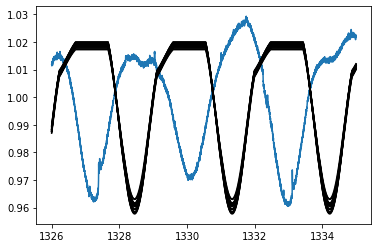

In [54]:
plt.plot(time, flux)

for p in pos: 
    
    lons = p[0:3]
    lats = p[3:6]
    rads = p[6:9]
    lc = s.light_curve(lons[:, None] * u.deg, lats[:, None] * u.deg, rads[:, None], 
                       inc_stellar=90*u.deg, times=time)[:, 0]

    lc /= np.mean(lc)

    plt.plot(time, lc, color='k')

In [55]:
with Pool() as pool:
    sampler = EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True);

# sampler = EnsembleSampler(nwalkers, ndim, log_probability)
# sampler.run_mcmc(pos, nsteps, progress=True);

100%|██████████| 5000/5000 [03:23<00:00, 24.61it/s]


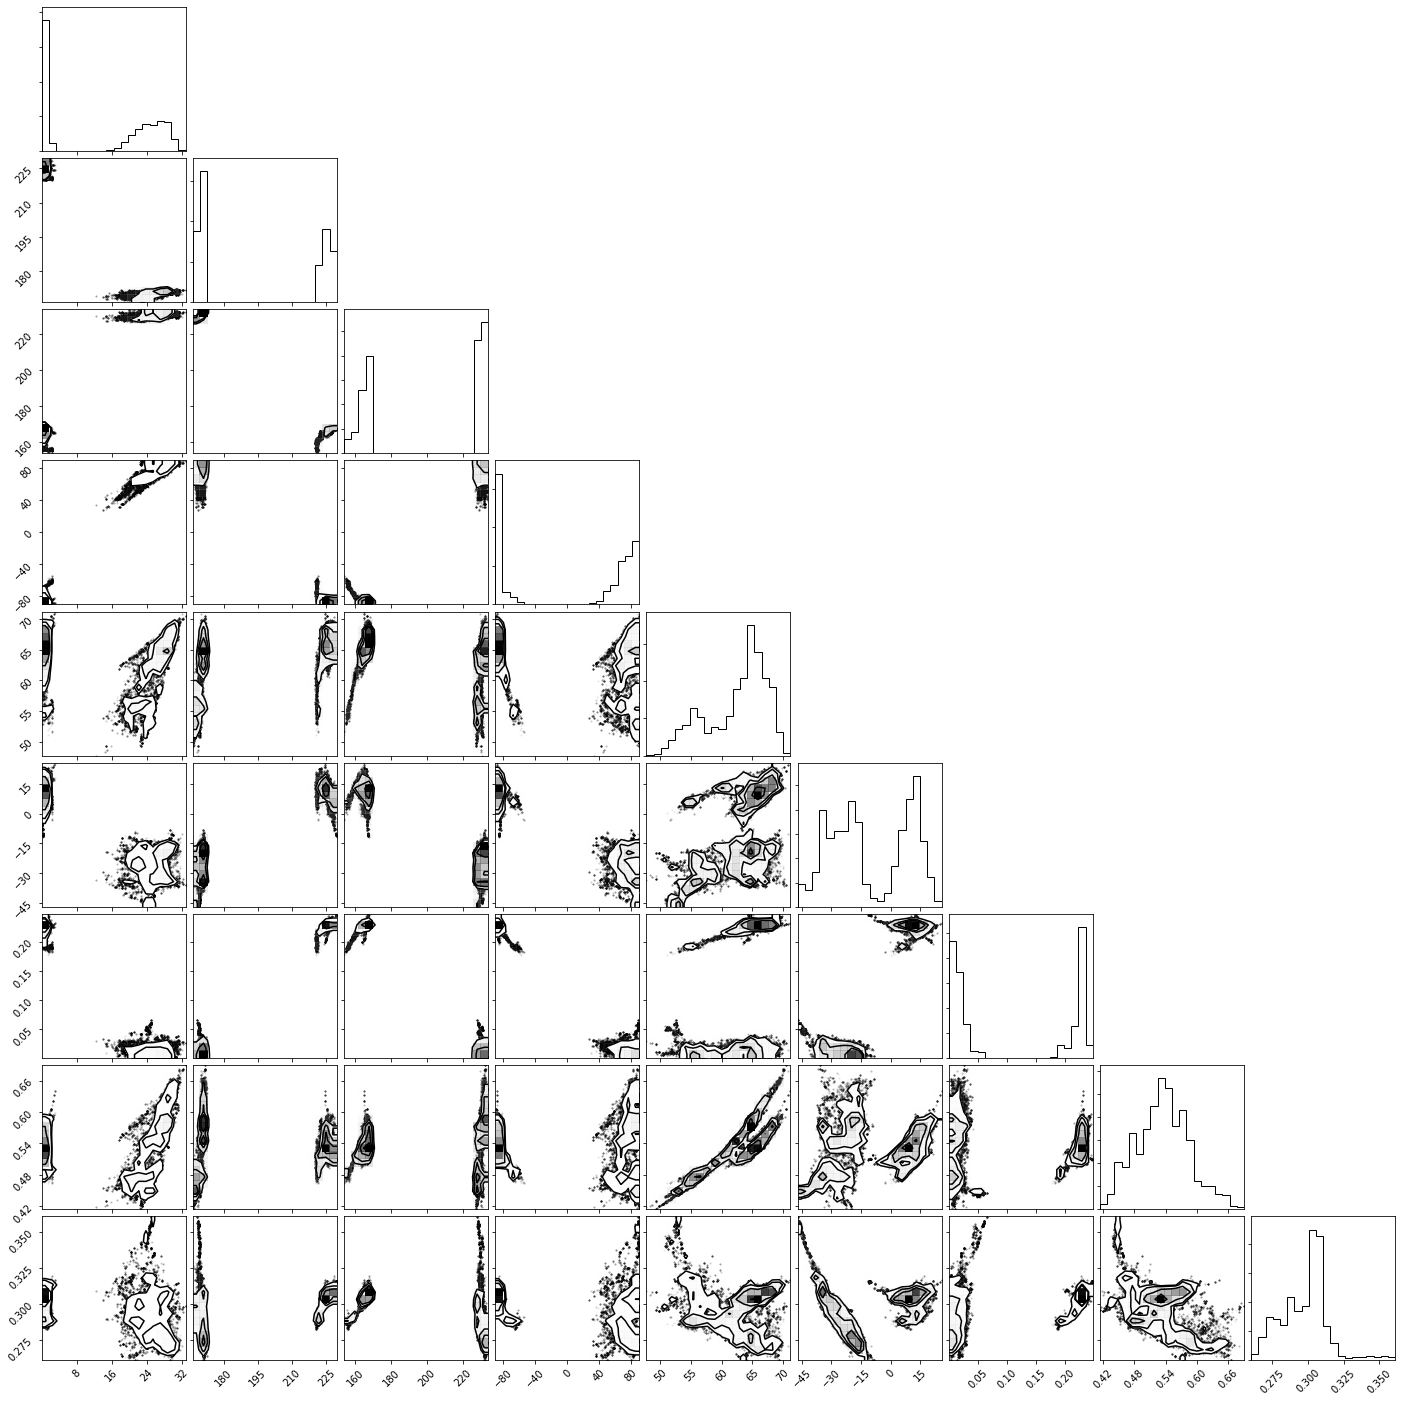

In [56]:
samples_burned_in = sampler.flatchain[len(sampler.flatchain)//2:, :]
corner(samples_burned_in);

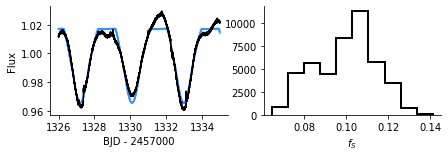

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(7, 2))    

for i in np.random.randint(0, len(samples_burned_in), size=50): 
    
    trial = samples_burned_in[i, :]
        
    lons = trial[0:3]
    lats = trial[3:6]
    rads = trial[6:9]
    
    lc = s.light_curve(lons[:, None] * u.deg, lats[:, None] * u.deg, rads[:, None], 
                       inc_stellar=90*u.deg, times=time, time_ref=0)[:, 0]
    ax[0].plot(time, lc/lc.mean(), color='DodgerBlue', alpha=0.05)

f_S = np.sum(samples_burned_in[:, -3:]**2 / 4, axis=1)
    
ax[0].plot(time, flux, color='k')
ax[1].hist(f_S, bins=10, histtype='step', lw=2, color='k')
ax[0].set(xlabel='BJD - 2457000', ylabel='Flux')
ax[1].set_xlabel('$f_S$')
for axis in ax: 
    for sp in ['right', 'top']:
        axis.spines[sp].set_visible(False)
fig.savefig('plots/DSTuc.pdf', bbox_inches='tight')

In [58]:
lo, mid, hi = np.percentile(f_S, [16, 50, 84])
f"$f_S = {{{mid:g}}}^{{+{hi-mid:g}}}_{{-{mid-lo:g}}}$"

'$f_S = {0.102167}^{+0.0119573}_{-0.0205112}$'